In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import astropy.constants as c
import astropy.units as u
import sys
sys.path.pop(1)
sys.path.insert(0,'../')
from matplotlib.colors import LogNorm

In [2]:
import pyathena as pa

In [60]:
ds=pa.AthenaDataSet('/tigress/changgoo/R16_16pc/id0/R16_16pc.0190.vtk')

In [61]:
star=pa.read_starvtk(ds.starfile)

In [62]:
den=ds.read_all_data('density')

In [63]:
slc=pa.AthenaSlice(ds,axis='z',center='center',field='density')

In [64]:
Nz,Ny,Nx=den.shape

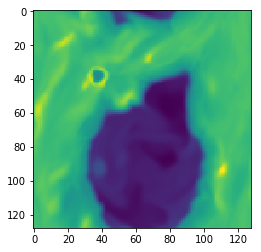

In [65]:
plt.imshow(den[Nz/2,:,:],norm=LogNorm())

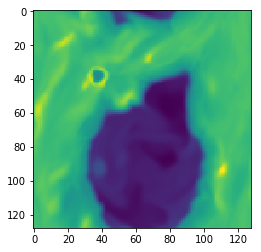

In [66]:
plt.imshow(slc.data,norm=LogNorm())

In [67]:
coolftn=pa.coolftn('../pyathena/coolftn.p')
temp=coolftn.get_temp(ds.read_all_data('T1'))

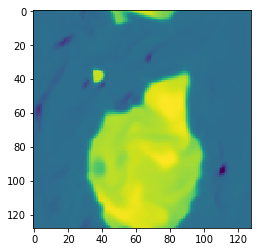

In [68]:
plt.imshow(temp[Nz/2,:,:],norm=LogNorm())

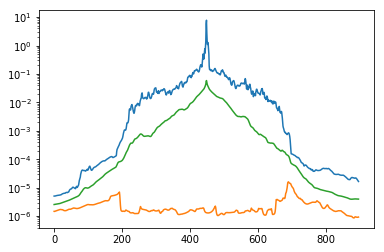

In [69]:
plt.semilogy(den.max(axis=1).max(axis=1))
plt.semilogy(den.min(axis=1).min(axis=1))
plt.semilogy(den.mean(axis=1).mean(axis=1))

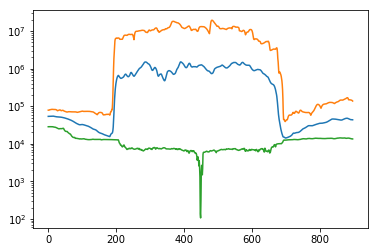

In [70]:
plt.semilogy(temp.mean(axis=1).mean(axis=1))
plt.semilogy(temp.max(axis=1).max(axis=1))
plt.semilogy(temp.min(axis=1).min(axis=1))

In [71]:
h=np.histogram2d(np.log10(den[Nz/2-10:Nz/2+10,...]).flatten(),
             np.log10(den[Nz/2-10:Nz/2+10,...]*temp[Nz/2-10:Nz/2+10,...]).flatten(),
             bins=[100,100],weights=den[Nz/2-10:Nz/2+10,...].flatten())

In [72]:
hst=pa.hst_reader('%s/id0/%s.hst' % (ds.dir,ds.id))

Reading a history file:/tigress/changgoo/R16_16pc//id0/R16_16pc.hst


In [73]:
hratio=np.interp(ds.domain['time'],hst.time,hst.heat_ratio)

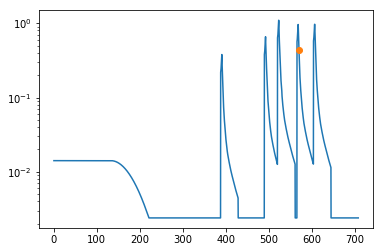

In [80]:
plt.plot(hst.time,hst.heat_ratio)
plt.plot(ds.domain['time'],np.interp(ds.domain['time'],hst.time,hst.heat_ratio),'o')
plt.yscale('log')

/tigress/changgoo/miniconda2/lib/python2.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in log10
  after removing the cwd from sys.path.


(0, 5)

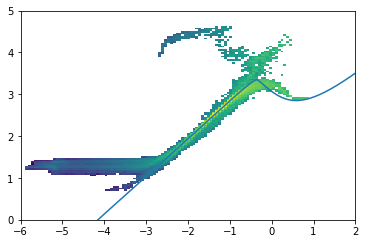

In [79]:
nden=coolftn.heat*hratio/coolftn.cool
pok=nden*coolftn.temp
plt.imshow(h[0].T,origin='lower',norm=LogNorm(),extent=[h[1].min(),h[1].max(),h[2].min(),h[2].max()])
plt.plot(np.log10(nden),np.log10(pok))
plt.xlim(-6,2)
plt.ylim(0,5)